Created on Wed Feb 06 11:34:21 2019 <br>
@author: zoldi.miklos
# <h1><center> Determining the effect of drift on misalignment of images taken by different filter cubes</center></h1>

Multi-color imaging using two separate fluorophores and filter cubes. Of course, there is chromatic aberration and the effect of filter cube change. But if these factors have small effect or can be calculated and corrected in control experiments, changing filter cubes should be an OK solution. However, the magnitude of misalignment seems to be bigger than just the above two effects. Is it because of the drift in the system? As both files are corrected independently, but not in respect to each other... <br>
***
### To-dos
- check whether amount of drift correlates with the amount of misalignement 
- direction of misalignemnt matches the direction of drift!!!! What to shift???
- Empirical shift: where it is much bigger than usually, is it because I waited longer time between images??
- do it on Susanne's files as there it iw more bovious what offset should be!!
***
- also include measurments from filter cube changes and chromatic aberration
- how drift is determined? New value in every 100 frame, and that value applied for another 100 frame?

In [1]:
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [7]:
###import modules
import align_miki_v1_noarg as align #function for alignment
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats
import itertools
from sklearn.cluster import DBSCAN

In [8]:
###import and set display and plotting styles
pd.set_option('max_rows', 3, 'max_colwidth',-1, 'max_columns', 20)
sns.set_style('darkgrid') #{'xtick.bottom':False, 'ytick.left':False}) 
%matplotlib inline 
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, gridplot
from bokeh.models import ColumnDataSource, DataTable, TableColumn, HoverTool, PointDrawTool, \
Legend, Arrow, NormalHead, Range1d
from bokeh.models.annotations import Label
from bokeh.palettes import Blues, Oranges
from bokeh.layouts import row, Column
output_notebook()

Loading BokehJS ...

In [9]:
###modified functions from align.py to match requirements
def load_2Channels(filename):
    '''read files and returns: drift corrected xyz coordinates as numpy array and the amount of xyz drift correction 
    xyz drift correction = drift corrected xyz - non-corrected xyz
    (opposite to the direction of the drift)'''
    
    dt = pd.read_csv(filename, delimiter='\t') #read as dataframes
    dt = dt[dt['Channel Name'].astype(str) != 'Z rejected'] 
    xyz_nc = dt[['Xw','Yw', 'Z']].values # convert to arrays (Use Z/Zc and not Zw/Zwc as the latter is not always drift corrected)
    xyz_c = dt[['Xwc','Ywc', 'Zc']].values #c = drift corrected xyz coord, nc = non-corrected
    #check amount of drift correction 
    xyz_driftCorr = xyz_c[-1] - xyz_nc[-1] #last row of array  (where drift should be maximal)
    return xyz_c, xyz_driftCorr


def prepare_2Channels(filename_1, filename_2, center_zoom_factor=0.25):
    '''load files and crop center of images
    the second image is also corrected by first image's drift correction''' 
    
    dt_1, xyz_driftCorr1 = load_2Channels(filename_1)
    dt_2, xyz_driftCorr2 = load_2Channels(filename_2) #amount of drift only needed for the first file 
    dt_2_driftCorr = dt_2 + xyz_driftCorr1
    
    box_1 = align.bounds(dt_1)
    box_2 = align.bounds(dt_2)
    box_2_driftCorr = align.bounds(dt_2_driftCorr)
    
    box = 0.33 * (box_1 + box_2 + box_2_driftCorr)
    box_center = 0.5 * (box[0, :] + box[1, :])
    box_edges = box[1, :] - box[0, :]
    factor = center_zoom_factor * 0.5
    crop_box = np.array([box_center - factor * box_edges,
                         box_center + factor * box_edges])
    dt_1 = align.crop_xy(dt_1, crop_box)
    dt_2 = align.crop_xy(dt_2, crop_box)
    dt_2_driftCorr = align.crop_xy(dt_2_driftCorr, crop_box)
    return dt_1, dt_2, dt_2_driftCorr, xyz_driftCorr1

-> load corresponding file pairs

In [26]:
### set variables: file locations, clustering parameters 
try:
    path = "L:/Miki/STORM_projects/Buffertests/180917_CF568_AF647_SAME_bassoon_imaging_time/plot_offsets/"
    file_list = path + "_filenames_all.txt"
    dt = pd.read_csv(file_list, sep='\t', dtype=str)
    fred_path = "L:/Miki/STORM_projects/Buffertests/180917_CF568_AF647_SAME_bassoon_imaging_time/analysis_FARRED//"
    red_path = "L:/Miki/STORM_projects/Buffertests/180917_CF568_AF647_SAME_bassoon_imaging_time/analysis_RED//"         
except Exception as exc:
        print exc
        print "file listing filenames not found" 
parameters = dict(
    dbscan_eps_1 = float(300),
    dbscan_min_samples_1 = int(10),
    dbscan_eps_2 = float(300),
    dbscan_min_samples_2 = int(10),
    border_size = float(200),
    center_zoom_factor = float(0.25),
    min_cluster_area_1 = 0,
    max_cluster_area_1 = float(np.inf),
    min_cluster_area_2 = 0,
    max_cluster_area_2 = float(np.inf))
dt

,Nr,first,second
0,0,Abbe_Sealed_Bas_AF647_CF568_sl01_105_s006_647_no405_list-2018-09-26-10-30-49_S01.bin_z_rejected.txt,Abbe_Sealed_Bas_AF647_CF568_sl01_105_s006_568_no405_list-2018-09-27-20-06-53_S01.bin_z_rejected.txt
...,...,...,...
121,121,Gloxy_Sealed_Bas_AF647_CF568_sl03_90_s006_647_no405_list-2018-09-26-10-30-49_S124.bin_z_rejected.txt,Gloxy_Sealed_Bas_AF647_CF568_sl03_90_s006_568_no405_list-2018-09-27-20-06-53_S124.bin_z_rejected.txt


***
# Determining empirical shift per file - aligning storm data manually
***

-> Get first xyz coordinates of the cropped area for 568 (second file, to be shifted) and xyz drift correction for 647 (first file, reference)

In [27]:
###write out filename, first xyz coordinate of prepared 568 file, drift for 647
# data_out = np.empty((0,6)) #first xyz coord of 568, xyz drift for 647 
# filenames = []
# for index, row in dt.iterrows(): 
#     try:
#         file_1 = fred_path + row['first']
#         file_2 = red_path + row['second']   
#         dt_1, dt_2, dt_2_driftCorr, xyz_driftCorr1 = prepare_2Channels(file_1, file_2, parameters['center_zoom_factor'])
#         print row['first']
#     except:
#         print exc
#         print 'skipping file: ', dt_per_file['first'], 'and continuing the process'
#     filenames.append(file_1)
#     curr_data = np.append(dt_2[0,:], xyz_driftCorr1)
#     data_out = np.append(data_out,[curr_data], axis=0)
# #write to file
# filenames = pd.DataFrame(filenames, columns=['filename'])
# data_out = pd.DataFrame(data=data_out, columns=['x0_original_568', 'y0_original_568','z0_original_568', 
#                                              'x_drift_647','y_drift_647', 'z_drift_647'])

# data_out = pd.concat([filenames,data_out],axis=1)
# data_out.to_csv(file_list.replace('.txt','_first_xyz568_drift.txt'),sep='\t', index=False)
data_out = pd.read_csv(file_list.replace('_filenames_all.txt','_filenames_all_first_xyz568_drift.txt'),delimiter='\t')
data_out

,filename,x0_original_568,y0_original_568,z0_original_568,x_drift_647,y_drift_647,z_drift_647
0,L:/Miki/STORM_projects/Buffertests/180917_CF568_AF647_SAME_bassoon_imaging_time/analysis_FARRED//Abbe_Sealed_Bas_AF647_CF568_sl01_105_s006_647_no405_list-2018-09-26-10-30-49_S01.bin_z_rejected.txt,22648.9,18140.0,-5.976,-30.5,5.1,-1.2210
...,...,...,...,...,...,...,...
121,L:/Miki/STORM_projects/Buffertests/180917_CF568_AF647_SAME_bassoon_imaging_time/analysis_FARRED//Gloxy_Sealed_Bas_AF647_CF568_sl03_90_s006_647_no405_list-2018-09-26-10-30-49_S124.bin_z_rejected.txt,21299.6,21455.1,-3.384,31.0,8.4,26.9972


-> display the corresponding files, drag and align the 568 channel to the 647 channel, and write the first aligned coordinate to the file manually. Subtract this from the original coordinate and get the empirical shift.

In [24]:
### figure for dragging second channel (568) to first channel by the user on individual files 
dt_per_file = dt.iloc[1] #select file 
#prepare file (read,crop)    
try:
    file_1 = fred_path + dt_per_file['first']
    file_2 = red_path + dt_per_file['second']   
    dt_1, dt_2, dt_2_driftCorr, xyz_driftCorr1 = prepare_2Channels(file_1, file_2, parameters['center_zoom_factor'])
except:
    print exc
    print 'skipping file: ', dt_per_file['first'], 'and continuing the process'

#plot data    
p = figure(match_aspect=True, x_axis_label='x-coordinates', y_axis_label='y-coordinates', 
                height=500, width=800, tools = "box_select,wheel_zoom,pan,reset", active_drag='box_select')

#create sources from dataframes converted from numpy array of xyz coordinates 
dt_1_source = pd.DataFrame(dt_1, columns=['x','y','z'])
dt_2_source = pd.DataFrame(dt_2, columns=['x','y','z'])
# dt_2_source_original = dt_2_source.copy(deep=True)
source1 = ColumnDataSource(dt_1_source)
source2 = ColumnDataSource(dt_2_source)

#get 647 and 568 points 
renderer1 = p.scatter(x='x', y='y', source=source1, color='red', size=5, legend ='647 - original')
renderer2 = p.scatter(x='x', y='y', source=source2, color='blue', size=5, legend ='568 - adjustable')

#get editable table with responsive 568 coordinates 
columns = [TableColumn(field="x", title="x"),
           TableColumn(field="y", title="y")]
table = DataTable(source=source2, columns=columns, editable=True, height=200) #edited even if editable=False??

#only renderer2 (568) is interactive for drag and drop
draw_tool = PointDrawTool(renderers=[renderer2], empty_value='black')
p.add_tools(draw_tool)

#edit plot style
table.width=200
p.x_range = Range1d(dt_1.min(axis=0)[0]-1000, dt_1.max(axis=0)[0]+1000) #adjust range to min-max x values
p.y_range = Range1d(dt_1.min(axis=0)[1]-1000, dt_1.max(axis=0)[1]+1000) #adjust range to min-max y values 
p.legend.click_policy='hide'
grid = gridplot([[p,table]], toolbar_location='above')
show(grid)

print "filename: ", dt_per_file['second']

filename:  Abbe_Sealed_Bas_AF647_CF568_sl01_120_s007_568_no405_list-2018-09-27-20-06-53_S02.bin_z_rejected.txt


-> (Alternative way: type the offset manually and display the original and offseted plots next to each other)

In [25]:
### or shift coordinates by manually typing xyz shift and compare it with the original image
offset = np.array([10,-300,0]) #set xyz offset
dt_per_file = dt.iloc[1] #select file
#prepare file (read,crop)   
try:
    file_1 = fred_path + dt_per_file['first']
    file_2 = red_path + dt_per_file['second']   
    dt_1, dt_2, dt_2_driftCorr, xyz_driftCorr1 = prepare_2Channels(file_1, file_2, parameters['center_zoom_factor'])
except:
    print exc
    print 'skipping file: ', dt_per_file['first'], 'and continuing the process'
dt_2_shifted = dt_2.copy() #copy original dataset
dt_2_shifted = dt_2_shifted + offset #apply offset

fig_specs = dict(match_aspect=True, x_axis_label='x-coordinates', y_axis_label='y-coordinates', 
                height=450, width=450)
#original
p1 = figure(**fig_specs)
a = p1.scatter(dt_1[:,0], dt_1[:,1], marker='circle', color='red', legend ='647')
b = p1.scatter(dt_2[:,0], dt_2[:,1], marker='circle', color='blue', legend ='568 - original')
p1.legend.click_policy='hide'

#shifted
p2 = figure(x_range=p1.x_range, y_range=p1.y_range, **fig_specs)
a = p2.scatter(dt_1[:,0], dt_1[:,1], marker='circle', color='red', legend ='647')
b = p2.scatter(dt_2_shifted[:,0], dt_2_shifted[:,1], marker='circle', color='blue', legend ='568 - shifted')
p2.legend.click_policy='hide'

grid = gridplot([[p1,p2]], toolbar_location='right')
show(grid)
print "filename: ", dt_per_file['second']
print "offset xyz: ", offset

filename:  Abbe_Sealed_Bas_AF647_CF568_sl01_120_s007_568_no405_list-2018-09-27-20-06-53_S02.bin_z_rejected.txt
offset xyz:  [  10 -300    0]


-> get file with empirical offset values

In [15]:
dt_offsets = pd.read_excel(path+"_filenames_drifts_all.xlsx", delimiter='\t')
dt_offsets = dt_offsets[dt_offsets['could_align'] == 'yes'] #where I more or less could determine the alignment empirically 
dt_offsets

,Nr,first,second,x0_original_568,y0_original_568,z0_original_568,x0_drag,y0_drag,z0_drag,x_offset,y_offset,z_offset,x_drift_647,y_drift_647,z_drift_647,could_align
0,0,Abbe_Sealed_Bas_AF647_CF568_sl01_105_s006_647_no405_list-2018-09-26-10-30-49_S01.bin_z_rejected.txt,Abbe_Sealed_Bas_AF647_CF568_sl01_105_s006_568_no405_list-2018-09-27-20-06-53_S01.bin_z_rejected.txt,22648.9,18140.0,-5.976,22630,18136.0,0,-18.9,-4.0,NaN,-30.5,5.1,-1.221,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,108,Gloxy_Sealed_Bas_AF647_CF568_sl02_75_s005_647_405_list-2018-09-26-10-30-49_S111.bin_z_rejected.txt,Gloxy_Sealed_Bas_AF647_CF568_sl02_75_s005_568_405_list-2018-09-27-20-06-53_S111.bin_z_rejected.txt,21422.4,17028.4,156.000,21410,17071.0,0,-12.4,42.6,NaN,-5.5,19.2,3.982,yes


-> display range of empirical xy offset values <br>
-> display range of empirical xy offset values if corrected for drift <br>
-> correlate drift and offset <br>

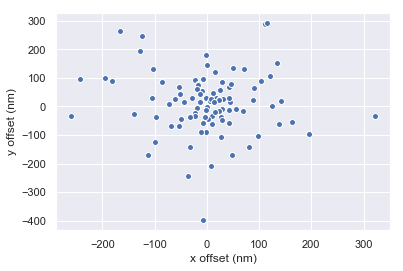

In [16]:
###plot x and y offset values as scatterplots
fig, ax = plt.subplots()
ax.scatter(dt_offsets['x_offset'],dt_offsets['y_offset'], marker='o', edgecolors='white')
# ax.set_aspect('equal')
# plt.xlim((-200,200)), plt.ylim((-200,200))
# plt.xticks(range(-300,350,50), rotation=45), plt.yticks(range(-300,350,50), rotation=45)
plt.xlabel('x offset (nm)')
plt.ylabel('y offset (nm)');

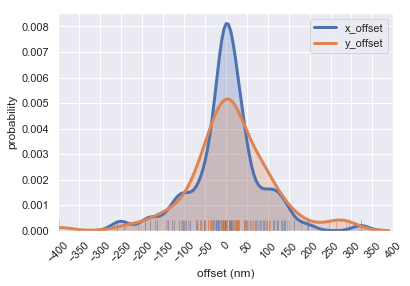

In [18]:
###plot both x and y offset values separately as shaded kde density plots (on their histograms)
# sns.set(rc={'figure.figsize':(10,5)}) #set figure size
# sns.set_context('poster') #make labels much bigger
for coordinate in ('x_offset', 'y_offset'):
    ax = sns.distplot(dt_offsets[coordinate], hist = False, kde = True, rug = True, label = coordinate,
                     kde_kws = {'shade': True, 'linewidth': 3}, rug_kws = {'linewidth': 0.5})
plt.xticks(range(-400,450,50), rotation=45)
plt.xlim((-400,400))
plt.ylabel('probability')
plt.xlabel('offset (nm)');

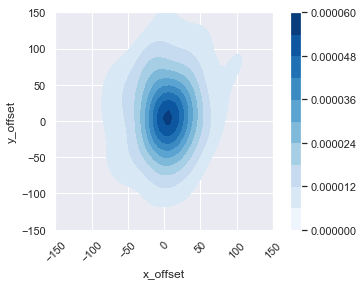

In [19]:
###plot x and y offsets as bivariate density plot - not displaying lowest probability
# sns.set(color_codes=True)
ax = sns.kdeplot(dt_offsets['x_offset'] , dt_offsets['y_offset'],  shade=True, shade_lowest=False, cmap="Blues", cbar=True)
ax.set_aspect('equal')
plt.xticks(range(-400,450,50), rotation=45)
plt.xlim((-150,150)), plt.ylim((-150,150));

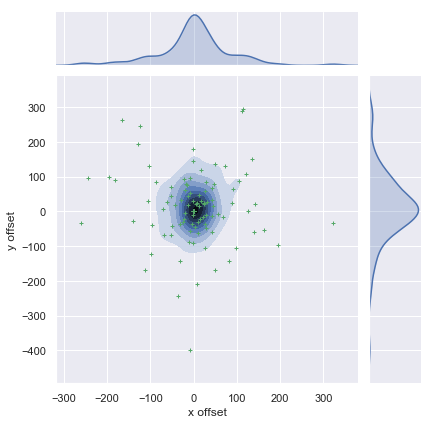

In [20]:
###plot every views :) 
g = sns.jointplot(x="x_offset", y="y_offset", data=dt_offsets, kind="kde", color="b")
g.plot_joint(plt.scatter, color="g", s=10, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("x offset", "y offset");

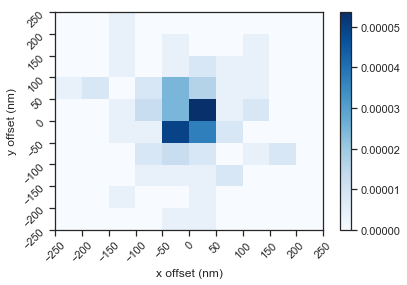

In [21]:
###2d histogram - temporally disable sns default darkgrid style; set to white with ticks
lim = (-250,250)
binwidth = 50
nbins = lim[1]/binwidth*2
#normalize histogram
# normed_x, edges_x= np.histogram(dt_offsets["x_offset"], bins=nbins, range=lim)
# normed_x = [i/float(np.sum(normed_x)) for i in normed_x]
# normed_y, edges_y= np.histogram(dt_offsets["y_offset"], bins=nbins, range=lim)
# normed_y = [i/float(np.sum(normed_y)) for i in normed_y]
# normed_x, normed_y
with sns.axes_style("ticks"):
    plt.hist2d(x="x_offset", y="y_offset", data=dt_offsets, bins=(nbins, nbins), range=(lim,lim), normed=True, cmap=plt.cm.Blues) 
    plt.colorbar()
    plt.xticks(range(lim[0],lim[1]+binwidth, binwidth), rotation=45)
    plt.yticks(range(lim[0],lim[1]+binwidth, binwidth), rotation=45)
    plt.xlim(lim), plt.ylim(lim)
    plt.xlabel('x offset (nm)'), plt.ylabel('y offset (nm)')

# -> Should check this

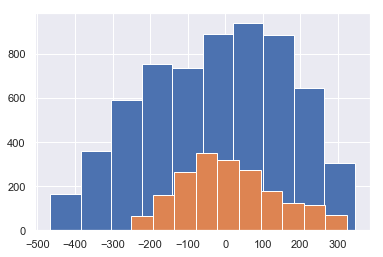

In [22]:
### figure showing that 647 coordinates have a wider (negative) range than for 568. Reason for that???
a = plt.hist(dt_1[:,2], bins =10)
b = plt.hist(dt_2[:,2], bins =10)
plt.show()

# -> running Bálint's code on all files

In [ ]:
###runs script and alignment for ALL files###
###reading filenames as path + fname (see parameters dict)
# def main():
offsetNonCorr_list = [] 
offsetCorr_list = [] #offset calculated on datasets where the second file was corrected for first file's drift 
driftCorr_list = [] #amount of drift correction (direction is opposite to drift, but should match direction of offset for alignment)

#dt_per_file = dt.iloc[0] #select only subset of files 
for index, row in dt.iterrows():
    print row['first']

    parameters = {
        'file_1': fred_path + row['first'],
        'file_2': red_path + row['second'],
        'dbscan_eps_1': dbscan_eps_1,
        'dbscan_min_samples_1': dbscan_min_samples_1,
        'dbscan_eps_2': dbscan_eps_2,
        'dbscan_min_samples_2': dbscan_min_samples_2,
        'border_size': border_size,
        'center_zoom_factor': center_zoom_factor,
        'min_cluster_area_1': min_cluster_area_1,
        'max_cluster_area_1': max_cluster_area_1,
        'min_cluster_area_2': min_cluster_area_2,
        'max_cluster_area_2': max_cluster_area_2}

    try:
        dt_1, dt_2, dt_2_driftCorr, dt_2_aligned_noDrift, dt_2_aligned_driftCorr, mean_offset1, mean_offset2, xyz_driftCorr1 = perform_alignment2(parameters)
    except Exception as exc:
        print exc
        print 'skipping file: ', row['first'], 'and continuing the process'
        continue
    offsetNonCorr_list.append(mean_offset1)
    offsetCorr_list.append(mean_offset2)
    driftCorr_list.append(xyz_driftCorr1)
        
#     return dt_1, dt_2, dt_2_aligned_noDrift, dt_2_aligned_DriftCorr

In [ ]:
p1 = figure(match_aspect=True, x_axis_label='x-coordinates', y_axis_label='y-coordinates', 
                height=500, width=950)
a = p1.scatter(dt_1[:,0], dt_1[:,1], marker='circle', color='blue', legend ='647 - original')
b = p1.scatter(dt_2[:,0], dt_2[:,1], marker='circle', color='red', legend ='568 - original')

# b2 = p1.scatter(dt_2_driftCorr[:,0], dt_2_driftCorr[:,1], marker='circle', color='purple', legend ='568 - drift-corrected')
# c = p1.scatter(dt_2_aligned_noDrift[:,0], dt_2_aligned_noDrift[:,1], marker='circle', color='green', legend ='568 - aligned')
# d = p1.scatter(dt_2_aligned_driftCorr[:,0], dt_2_aligned_driftCorr[:,1], marker='circle', color='pink', legend ='568 - dc_aligned')
p1.legend.click_policy='hide'
show(p1)

In [ ]:
p2 = figure(match_aspect=True, x_axis_label='x-drift (nm)', y_axis_label='y-drift (nm)', 
            height=400, width=400)
p2.circle(x=[0, mean_offset1[0]], y=[0, mean_offset1[1]], color='green', legend='offset1 (non-corrected) ')
p2.add_layout(Arrow(end=NormalHead(fill_color='green'), x_start=0,
                    y_start=0, x_end=mean_offset1[0], y_end=mean_offset1[1]))
p2.circle(x=[0, mean_offset2[0]], y=[0, mean_offset2[1]], color='pink', legend='offset2 (corrected)')
p2.add_layout(Arrow(end=NormalHead(fill_color='pink'), x_start=0,
                    y_start=0, x_end=mean_offset2[0], y_end=mean_offset2[1]))
p2.circle(x=[0, xyz_driftCorr1[0]], y=[0, xyz_driftCorr1[1]], color='black', legend='drift correction (file1)')
p2.add_layout(Arrow(end=NormalHead(fill_color='black'), x_start=0,
                    y_start=0, x_end=xyz_driftCorr1[0], y_end=xyz_driftCorr1[1]))
show(p2)

***
# Plotting the drifts and offsets as histograms
***

In [ ]:
x_drifts, y_drifts = np.array([i[0] for i in driftCorr_list]), np.array([i[1] for i in driftCorr_list])
x_offsets, y_offsets = np.array([i[0] for i in offsetNonCorr_list]), np.array([i[1] for i in offsetNonCorr_list])
x_offsetsCorr, y_offsetsCorr = np.array([i[0] for i in offsetCorr_list]), np.array([i[1] for i in offsetCorr_list])

In [ ]:
#figure to plot the extent of drift and offsets using histograms (bokeh)
extent = (-300,300)
bins = 12
normed = True #normalized histogram (to the number off all occurences, NOT probability density function)

hist_xDrift, edges_xDrift= np.histogram(x_drifts, density=False, bins=bins, range=extent)
hist_yDrift, edges_yDrift= np.histogram(y_drifts, density=False, bins=bins, range=extent)
hist_xOffset, edges_xOffset= np.histogram(x_offsets, density=False, bins=bins, range=extent)
hist_yOffset, edges_yOffset= np.histogram(y_offsets, density=False, bins=bins, range=extent)
hist_xOffsetCorr, edges_xOffsetCorr= np.histogram(x_offsetsCorr, density=False, bins=bins, range=extent)
hist_yOffsetCorr, edges_yOffsetCorr= np.histogram(y_offsetsCorr, density=False, bins=bins, range=extent)
if normed:
    hist_xDrift = [i/float(np.sum(hist_xDrift)) for i in hist_xDrift]
    hist_yDrift = [i/float(np.sum(hist_yDrift)) for i in hist_yDrift]
    hist_xOffset = [i/float(np.sum(hist_xOffset)) for i in hist_xOffset]
    hist_yOffset = [i/float(np.sum(hist_yOffset)) for i in hist_yOffset]
    hist_xOffsetCorr = [i/float(np.sum(hist_xOffsetCorr)) for i in hist_xOffsetCorr]
    hist_yOffsetCorr = [i/float(np.sum(hist_yOffsetCorr)) for i in hist_yOffsetCorr]
    
p5_0 = figure(match_aspect=True, x_axis_label='Drift (nm)', y_axis_label='% of occurences', 
            height=400, width=400)
p5_0.quad(top=hist_xDrift, bottom=0, left=edges_xDrift[:-1], right=edges_xDrift[1:],
           fill_color="darkgreen", line_color="white", alpha=0.5, legend='X-drift')
p5_0.quad(top=hist_yDrift, bottom=0, left=edges_yDrift[:-1], right=edges_yDrift[1:],
           fill_color="lightgreen", line_color="white", alpha=0.5, legend='Y-drift')
p5_0.y_range.start = 0
p5_0.y_range.end = np.max(hist_xDrift)

p5_1 = figure(match_aspect=True, x_axis_label='Offset (nm)', y_axis_label='% of occurences', 
            height=400, width=400)

p5_1.quad(top=hist_xOffset, bottom=0, left=edges_xOffset[:-1], right=edges_xOffset[1:],
           fill_color="darkblue", line_color="white", alpha=0.5, legend='X-offset')
p5_1.quad(top=hist_yDrift, bottom=0, left=edges_yOffset[:-1], right=edges_yOffset[1:],
           fill_color="lightblue", line_color="white", alpha=0.5, legend='Y-offset')
p5_1.y_range.start = 0
p5_1.y_range.end = np.max(hist_xOffset)
p5_1.legend.click_policy='hide'

p5_2 = figure(match_aspect=True, x_axis_label='Offset (nm)', y_axis_label='% of occurences', 
            height=400, width=400)

p5_2.quad(top=hist_xOffsetCorr, bottom=0, left=edges_xOffsetCorr[:-1], right=edges_xOffsetCorr[1:],
           fill_color="red", line_color="white", alpha=0.5, legend='X-offset (drift-corr)')
p5_2.quad(top=hist_yDrift, bottom=0, left=edges_yOffset[:-1], right=edges_yOffset[1:],
           fill_color="coral", line_color="white", alpha=0.5, legend='Y-offset (drift-corr)')
p5_2.y_range.start = 0
p5_2.y_range.end = np.max(hist_xOffsetCorr)
p5_2.legend.click_policy='hide'

grid = gridplot([[p5_0, p5_1, p5_2]])

show(grid)

## very same using matplotlib
# fig, axis = plt.subplots(1,1)
# hist = axis.hist(x_drifts, bins=12, density=True)
# plt.show(hist)

# Plotting drift vs offset - correlation
***

In [ ]:
#figure to check whether amount of drift correlates with the amount of shift needed to apply 
#separately for X and Y coordinates 
p3_0 = figure(match_aspect=True, x_axis_label='X drift correction (nm)', y_axis_label='X offset (nm)', 
            height=400, width=400)
p3_0.circle(x=x_drifts, y=x_offsets, color='green', legend='X-offset (non-corrected) ')
p3_0.circle(x=x_drifts, y=x_offsetsCorr, color='purple', legend='X-offset (corrected) ')
p3_0.legend.click_policy='hide'
# p3_0.circle(x=driftCorr_list, y=offsetCorr_list, color='pink', legend='X-offset (corrected) ')

p3_1 = figure(match_aspect=True, x_axis_label='Y drift correction (nm)', y_axis_label='Y offset (nm)', 
            height=400, width=400)
p3_1.circle(x=y_drifts, y=y_offsets, color='green', legend='Y-offset (non-corrected) ')
p3_1.circle(x=y_drifts, y=y_offsetsCorr, color='purple', legend='Y-offset (corrected) ')
p3_1.legend.click_policy='hide'


#estimate correlation
gradient_X, intercept_X, rValue_X, pValue_X, stdErr_X = stats.linregress(x_drifts, x_offsets)
gradient_XCorr, intercept_XCorr, rValue_XCorr, pValue_XCorr, stdErr_XCorr = stats.linregress(x_drifts, x_offsetsCorr)
gradient_Y, intercept_Y, rValue_Y, pValue_Y, stdErr_Y = stats.linregress(y_drifts, y_offsets)
gradient_YCorr, intercept_YCorr, rValue_YCorr, pValue_YCorr, stdErr_YCorr = stats.linregress(y_drifts, y_offsetsCorr)
#plot fitted 
p3_0.line(x_drifts, intercept_X + gradient_X*x_drifts, color='green', line_width=2, line_alpha=0.6)
p3_0.line(x_drifts, intercept_XCorr + gradient_XCorr*x_drifts, color='purple', line_width=2, line_alpha=0.6)
p3_1.line(y_drifts, intercept_Y + gradient_Y*y_drifts, color='green', line_width=2, line_alpha=0.6)
p3_1.line(y_drifts, intercept_YCorr + gradient_YCorr*y_drifts, color='purple', line_width=2, line_alpha=0.6)
#show plot
grid = gridplot([[p3_0, p3_1]])
show(grid)
#print data
print "X-coordinate:"
print "Original: slope: %f \t r-squared: %f" % (gradient_X, rValue_X**2)
print "Corrected: slope: %f \t r-squared: %f \n" % (gradient_XCorr, rValue_XCorr**2)

print "Y-coordinate:"
print "Original: slope: %f \t r-squared: %f" % (gradient_Y, rValue_Y**2)

print "Corrected: slope: %f \t r-squared: %f" % (gradient_YCorr, rValue_YCorr**2)

***
# Drug - ligand images on cells from Susanne
***

In [ ]:
import os 
S_path = "W:/Zsuzska/DRD3/phs/ABP535/PD-kiserletek/190123//" #s / cf
S_fredPath = S_path + "190123-s//"
S_redPath= S_path + "190123-cf//"
S_fredFiles = os.listdir(S_fredPath)
S_fredFiles = [i for i in S_fredFiles if i.endswith(".bin.txt")] 
S_redFiles = os.listdir(S_redPath)
S_redFiles = [i for i in S_redFiles if i.endswith(".bin.txt")] 

In [ ]:
### or for combined files
import os 
S_path = "W:/Zsuzska/DRD3/phs/ABP535/PD-kiserletek/190123//" #s / cf
S_combinedPath = S_path + "190123-analizis//"
S_combinedFiles = os.listdir(S_combinedPath)
S_combinedFiles = [i for i in S_combinedFiles if i.endswith("RoiCoords.txt")] 

In [ ]:
dt1 = pd.read_csv(S_fredPath+S_fredFiles[0], delimiter='\t') #read as dataframes
dt1 = dt1[dt1['Channel Name'].astype(str) != 'Z Rejected'] 
xyz_nc1 = dt1[['Xw','Yw', 'Z']].values

dt2 = pd.read_csv(S_redPath+S_redFiles[0], delimiter='\t') #read as dataframes
dt2 = dt2[dt2['Channel Name'].astype(str) != 'Z Rejected'] 
xyz_nc2 = dt2[['Xw','Yw', 'Z']].values

In [ ]:
### or for combined Results (Roicoords) files
for i in range(10):
    dt = pd.read_csv(S_combinedPath+S_combinedFiles[i], delimiter='\t') #read as dataframes
    dt1 = dt[dt['Channel Name'].astype(str) == '405/647'] 
    xyz_nc1 = dt1[['Xw','Yw', 'Z']].values

    dt2 = dt[dt['Channel Name'].astype(str) == '405/561'] 
    xyz_nc2 = dt2[['Xw','Yw', 'Z']].values
    
    mean_fred = np.mean(xyz_nc1, axis=0)
    mean_red = np.mean(xyz_nc2, axis=0)
   
    offset = mean_fred - mean_red
    print offset

    xyz_nc2_offset = xyz_nc2+offset
    
    i = figure()
    i.circle(x=xyz_nc1[:,0], y=xyz_nc1[:,1], color='blue', legend='fred')
    i.circle(x=xyz_nc2[:,0], y=xyz_nc2[:,1], color='red', legend='red')
#     i.circle(x=xyz_nc2_offset[:,0], y=xyz_nc2_offset[:,1], color='green', legend='red_offseted')
    i.circle(mean1[0], mean1[1], fill_color='pink', line_color='blue', size=30, alpha=0.8)
    i.circle(mean2[0], mean2[1], fill_color='pink', line_color='red', size=30, alpha=0.8)
    i.legend.click_policy='hide'
    show(i)

In [ ]:
####observe my files in a similar way 

# fred_path = "W:/Miki/STORM_projects/Buffertests/180917_CF568_AF647_SAME_bassoon_imaging_time/analysis_FARRED//"
# red_path = "W:/Miki/STORM_projects/Buffertests/180917_CF568_AF647_SAME_bassoon_imaging_time/analysis_RED//" 
# fredFiles = os.listdir(fred_path)[0:5]
# fredFiles = [i for i in fredFiles if i.endswith(".bin_z_rejected.txt")]
# redFiles = os.listdir(red_path)[0:5]
# redFiles = [i for i in redFiles if i.endswith(".bin_z_rejected.txt")] 


# for i in range(5):
#     dt = pd.read_csv(fred_path+fredFiles[i], delimiter='\t') #read as dataframes
#     dt1 = dt[dt['Channel Name'].astype(str) == '647'] 
#     xyz_nc1 = dt1[['Xw','Yw', 'Z']].values

#     dt = pd.read_csv(red_path+redFiles[i], delimiter='\t')
#     dt2 = dt[dt['Channel Name'].astype(str) == '561'] 
#     xyz_nc2 = dt2[['Xw','Yw', 'Z']].values
    
#     mean_fred = np.mean(xyz_nc1, axis=0)
#     mean_red = np.mean(xyz_nc2, axis=0)
   
#     offset = mean_fred - mean_red
#     print offset

#     xyz_nc2_offset = xyz_nc2+offset
    
#     i = figure()
#     i.circle(x=xyz_nc1[:,0], y=xyz_nc1[:,1], color='blue', legend='fred')
#     i.circle(x=xyz_nc2[:,0], y=xyz_nc2[:,1], color='red', legend='red')
# #     i.circle(x=xyz_nc2_offset[:,0], y=xyz_nc2_offset[:,1], color='green', legend='red_offseted')
#     i.circle(mean1[0], mean1[1], fill_color='pink', line_color='blue', size=30, alpha=0.8)
#     i.circle(mean2[0], mean2[1], fill_color='pink', line_color='red', size=30, alpha=0.8)
#     i.legend.click_policy='hide'
#     show(i)

In [ ]:
mean_fred = np.mean(xyz_nc1, axis=0)
mean_red = np.mean(xyz_nc2, axis=0)
offset = mean_fred - mean_red
print offset

xyz_nc2_offset = xyz_nc2+offset

In [ ]:
p = figure()
p.circle(x=xyz_nc1[:,0], y=xyz_nc1[:,1], color='blue', legend='fred')
p.circle(x=xyz_nc2[:,0], y=xyz_nc2[:,1], color='red', legend='red')
p.circle(x=xyz_nc2_offset[:,0], y=xyz_nc2_offset[:,1], color='green', legend='red_offseted')
p.circle(mean1[0], mean1[1], fill_color='pink', line_color='blue', size=30, alpha=0.8)
p.circle(mean2[0], mean2[1], fill_color='pink', line_color='red', size=30, alpha=0.8)
p.legend.click_policy='hide'
show(p)

In [ ]:
from scipy.spatial import procrustes
a = np.array([[1, 1], [2, 2], [3, 3], [4, 4]], 'd')
b = np.array([[2, 5], [3, 6], [4, 7], [5, 8]], 'd')
mtx1, mtx2, disparity = procrustes(a, b)

In [ ]:
#generate datasets with identical length
xyz_nc1 = xyz_nc1[:len(xyz_nc2)]
assert len(xyz_nc1) == len(xyz_nc2)

In [ ]:
# calculate which transformation has the smallest disparity
import random
x_offsets = [0,500,2000]
y_offsets = [0,500,2000]
fred = xyz_nc1
red = xyz_nc2
disparities = []
offsets = []
mtx1s = []
mtx2s = []
for i in x_offsets:
    for j in y_offsets:
        
        offset = np.array([i,j,0.0]) #0 offset in z
        #offset dataset with given offset
        xyz_nc2_offset = xyz_nc2*random.random()
        mtx1, mtx2, disparity = procrustes(xyz_nc1, xyz_nc2_offset)
        mtx1s.append(mtx1)
        mtx2s.append(mtx2)
        disparities.append(disparity)
        offsets.append(offset)
        
        fig = str(offset)
        fig = figure(width=400, height=400)
        fig.circle(x=xyz_nc2_offset[:,0], y=xyz_nc2_offset[:,1], color='blue', legend='shifted')
        fig.circle(x=xyz_nc2[:,0], y=xyz_nc2[:,1], color='red', legend='original')
        fig.legend.click_policy='hide'
        show(fig)
        
        

In [ ]:
mtx1s

In [ ]:
for i,j in enumerate (mtx1s):
#     if i.all() == mtx1s[-1]:
#         break
    print mtx1s[i] == mtx1s[i+1]
    print i

In [ ]:
p = figure(width=400, height=400)
p.circle(x=a[:,0], y=a[:,1], color='blue')
p.circle(x=b[:,0], y=b[:,1], color='red')
show(p)

p1 = figure(width=400, height=400)
p1.circle(x=xyz_nc1[:,0], y=xyz_nc1[:,1], color='blue', legend='fred')
p1.circle(x=xyz_nc2[:,0], y=xyz_nc2[:,1], color='red', legend='red')
p1.legend.click_policy='hide'
show(p1)

In [ ]:
mean1, mean2, offset


***
# Plot deviations from 0.0
***

In [ ]:
distancesCorr = []
for i in offsetCorr_list:
    distance = np.sqrt(i[0]**2 + i[1]**2 + i[2]**2)
    distancesCorr.append(distance)
    
distancesNonCorr = []
for i in offsetNonCorr_list:
    distance = np.sqrt(i[0]**2 + i[1]**2 + i[2]**2)
    distancesNonCorr.append(distance)
    
# p4_0 = figure(match_aspect=True, x_axis_label='drift correction (nm)', y_axis_label='distance', 
#             height=600, width=600)
# p4_0.circle(x=x_drifts, y=distancesCorr, color='green', legend='X dist ')
# p4_0.circle(x=y_drifts, y=distancesCorr, color='purple', legend='y dist ')
# p4_0.legend.click_policy='hide'
# show(p4_0)

# fig, (ax1, ax2) = plt.subplots(1,2)
# hist1 = ax1.hist(distancesCorr, bins=12, density=True)
# hist2 = ax2.hist(distancesNonCorr, bins=12, density=True)
# plt.tight_layout()
# plt.show()

***
# <font color='red'> Trying different things </font>
***

In [ ]:
### 2d histogram for xy drift using bokeh hexbin functions 
### not the best, as it is difficult to see it with hexagonal bins. Would be better using square grids
### matplotlib has this functionality
p_2dhist = figure(title="2d histogram", match_aspect=True)
p_2dhist.grid.visible = False
r, bins = p_2dhist.hexbin(np.array(x_drifts), np.array(y_drifts), size=50, palette='Spectral11')
show(p_2dhist)

In [ ]:
###using matplotlib
###do not understand why range of 2d histogram is getting smaller and smaller after every invocation of hist2d?????!!!


# fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(5, 15),  tight_layout=True)                    
fig = plt.figure(figsize=(10,10))
# plt.subplot(1,3,1)
ax1 = fig.add_subplot(1,3,1, aspect='equal')
ax1.hist2d(x_drifts, y_drifts, bins=10, cmin=0, alpha=0.8)
# ymin, ymax = ax1.get_ylim()
# xmin, xmax = ax1.get_xlim()
ax1.set_xlim(-200,200)
ax1.set_ylim(-200,200)
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.title("2d histogram of drift")

# plt.subplot(1,3,2)
ax2 = fig.add_subplot(1,3,2, aspect='equal')#, sharex=ax1, sharey=ax1)
ax2.hist2d(x_offsets, y_offsets, bins=10, cmin=0, alpha=0.8)
ax2.set_xlim(-200,200)
ax2.set_ylim(-200,200)
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.title("2d histogram of offset")

# plt.subplot(1,3,3)
ax3 = fig.add_subplot(133, aspect='equal')#, sharex=ax1, sharey=ax1)
ax3.hist2d(x_offsetsCorr, y_offsetsCorr, bins=10, cmin=0, alpha=0.8)
ax3.set_xlim(-200,200)
ax3.set_ylim(-200,200)
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.title("2d histogram of offset \n (drift-corrected)")

plt.tight_layout()
plt.show()

In [ ]:
###example how to use bokeh hexbin() function
###not so nice if replaced with my data

import numpy as np

from bokeh.plotting import figure, show
from bokeh.layouts import row

# normal distribution center at x=0 and y=5
x = np.random.randn(100000)
y = np.random.randn(100000) + 5

H, xe, ye = np.histogram2d(x, y, bins=100)

# produce an image of the 2d histogram
p = figure(x_range=(min(xe), max(xe)), y_range=(min(ye), max(ye)), title='Image')

p.image(image=[H], x=xe[0], y=ye[0], dw=xe[-1] - xe[0], dh=ye[-1] - ye[0], palette="Spectral11")

# produce hexbin plot
p2 = figure(title="Hexbin", match_aspect=True)
p.grid.visible = False

r, bins = p2.hexbin(np.array(x_drifts), np.array(y_drifts), size=1, hover_color="pink", hover_alpha=0.8, palette='Spectral11')

show(row(p, p2))

## Resources
### Set seaborn default styles
- https://seaborn.pydata.org/tutorial/aesthetics.html

### Histograms / density plots
- general: https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0
- general: https://realpython.com/python-histograms/
- bivariate + univariate: https://seaborn.pydata.org/tutorial/distributions.html
- 2d histograms:https://python-graph-gallery.com/2d-density-plot/
- in bokeh(semmes to be difficult): simple histogram https://bokeh.pydata.org/en/latest/docs/gallery/histogram.html
- hexbin: https://bokeh.pydata.org/en/latest/docs/gallery/hexbin.html , https://stackoverflow.com/questions/50975814/histogram2d-example-for-bokeh

### Correlation
- https://stackoverflow.com/questions/19068862/how-to-overplot-a-line-on-a-scatter-plot-in-python/19069001#19069001 <br>
scipy
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html <br>
seaborn
- http://seaborn.pydata.org/generated/seaborn.lmplot.html#seaborn.lmplot

### Moving points on plots
- https://stackoverflow.com/questions/30184926/bokeh-how-to-click-and-drag